In [1]:
import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def crop(img, roi):
    return img[roi[0][1]:roi[1][1], roi[0][0]:roi[1][0]]

def warp_matrix(P):
  W = np.array([[1 + P[0, 0], P[2, 0], P[4, 0]],
                [P[1, 0], 1 + P[3, 0], P[5, 0]] ])
                # [0, 0, 1]])
  return W

def get_dw_dp(X):
  return np.array([[X[0], 0, X[1], 0, 1, 0],
                  [0, X[0], 0, X[1], 0, 1]])

In [4]:
frames_of_car_video = np.load("/content/drive/MyDrive/ass/car2.npy")
frames_of_plane_video = np.load("/content/drive/MyDrive/ass/Copy of landing.npy")

In [5]:
frames_of_car_video.shape

(240, 320, 415)

In [6]:
bbox = [50, 110, (155 - 50), (162 - 110)]
template = crop(frames_of_car_video[:,:,0], [[50, 110], [155, 162]]) / 255.0
I0 = frames_of_car_video[:,:,1] / 255.0

# template2 = frames_of_plane_video[:, :, 50]

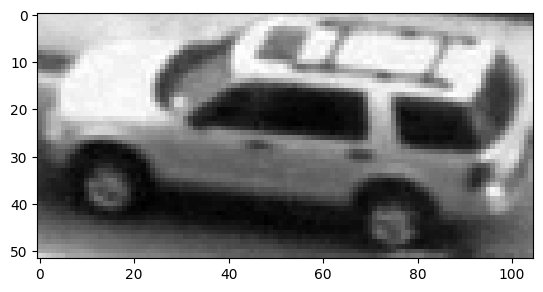

In [7]:
plt.imshow(template, cmap='gray');

In [8]:
template.shape[0] * template.shape[1]

5460

In [9]:
def draw_bounding_boxes(img, bounding_boxes):
  # Create figure and axes
  fig, ax = plt.subplots(1)

  # Display the image
  ax.imshow(img, cmap='gray')

  # Add bounding boxes to the image
  x_min, y_min, x_max, y_max = bounding_boxes
  rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
  ax.add_patch(rect)

  # Display the image
  plt.show()

In [10]:
def LK_tracker(I0, template, X, w, h, P, threshold=0.01, max_iter=100, warp_type="point"):
  iter, delta_p_norm = 0, np.inf
  while (delta_p_norm > threshold) and (iter < max_iter):
    iter += 1
    W = warp_matrix(P)
    if warp_type != "point":
      warped_image = cv2.warpAffine(I0, W, (I0.shape[1], I0.shape[0]))
    X_2 = np.array([X[0] + w, X[1] + h, 1])
    X_1_prime = np.matmul(W, X).astype(int)
    X_2_prime = np.matmul(W, X_2).astype(int)
    if warp_type == "point":
      I0_cropped = crop(I0, [X_1_prime, X_2_prime])
    else:
      I0_cropped = crop(warped_image, [X, X_2])
    grad_x_T = cv2.Sobel(template, cv2.CV_64F, 1, 0, ksize=3).flatten()
    grad_y_T = cv2.Sobel(template, cv2.CV_64F, 0, 1, ksize=3).flatten()
    grad_x_I = cv2.Sobel(I0_cropped, cv2.CV_64F, 1, 0, ksize=3).flatten()
    grad_y_I = cv2.Sobel(I0_cropped, cv2.CV_64F, 0, 1, ksize=3).flatten()
    delta_T = np.stack((grad_x_T, grad_y_T), axis=1)
    delta_I = np.stack((grad_x_I, grad_y_I), axis=1)
    H = np.zeros((6, 6))
    A = np.zeros((1, 6))
    b = 0
    template = template.flatten()
    I0_cropped = I0_cropped.flatten()
    for x in range(min(template.shape[0], I0_cropped.shape[0])):
      dw_dp = get_dw_dp([x, 1])
      H += np.matmul(np.matmul(delta_I[x], dw_dp).T, np.matmul(delta_I[x], dw_dp))
      A += np.matmul(delta_I[x], dw_dp)
      b += abs(template[x] - I0_cropped[x])
    delta_p = np.linalg.pinv(H) @ A.T @ b.reshape(1, -1)
    P = P + delta_p
    delta_p_norm = np.linalg.norm(delta_p)
  return P

## Warping The Bounding Box

In [ ]:
bbox = [50, 110, (155 - 50), (162 - 110)]
template = crop(frames_of_car_video[:,:,0], [[50, 110], [155, 162]]) / 255.0

P = np.zeros((6, 1))
X = [50, 110, 1]
X_orig = [50, 110, 1]
w, h = 105, 52

for i in range(1, frames_of_car_video.shape[-1]):
  image = frames_of_car_video[:, :, i] / 255.0
  image_copy = copy.deepcopy(image)
  template_copy = copy.deepcopy(template)
  P = LK_tracker(image_copy, template_copy, X_orig, w, h, P, threshold=0.01, warp_type="point")
  W = warp_matrix(P)
  X = np.matmul(W, X_orig).astype(int)
  print(f"Frame No: {i} - {X}")
  draw_bounding_boxes(image, [X[0], X[1], X[0] + w, X[1] + h])

## Warping The Image

In [ ]:
bbox = [50, 110, (155 - 50), (162 - 110)]
template = crop(frames_of_car_video[:,:,0], [[50, 110], [155, 162]]) / 255.0

P = np.zeros((6, 1))
X = [50, 110, 1]
X_orig = [50, 110, 1]
w, h = 105, 52

for i in range(1, frames_of_car_video.shape[-1]):
  image = frames_of_car_video[:, :, i] / 255.0
  image_copy = copy.deepcopy(image)
  template_copy = copy.deepcopy(template)
  P = LK_tracker(image_copy, template_copy, X_orig, w, h, P, threshold=0.01, warp_type="img")
  W = warp_matrix(P)
  warped_image = cv2.warpAffine(image, W, (image.shape[1], image.shape[0]))
  print(f"Frame No: {i} - {X}")
  draw_bounding_boxes(warped_image, [X[0], X[1], X[0] + w, X[1] + h])

## Same Implementation Of Lukas Kanade Tracker But With Full Matrices

In [15]:
def LK_tracker_full_shape(I0, template, X, w, h, P, threshold=0.01):
  delta_p_norm = np.inf
  while delta_p_norm > threshold:
    W = warp_matrix(P)
    X_2 = np.array([X[0] + w, X[1] + h, 1])
    X_1_prime = np.matmul(W, X).astype(int)
    X_2_prime = np.matmul(W, X_2).astype(int)
    I0_cropped = I0
    grad_x_T = cv2.Sobel(template, cv2.CV_64F, 1, 0, ksize=3)
    grad_y_T = cv2.Sobel(template, cv2.CV_64F, 0, 1, ksize=3)
    grad_x_I = cv2.Sobel(I0_cropped, cv2.CV_64F, 1, 0, ksize=3)
    grad_y_I = cv2.Sobel(I0_cropped, cv2.CV_64F, 0, 1, ksize=3)
    delta_T = np.stack((grad_x_T, grad_y_T), axis=2)
    delta_I = np.stack((grad_x_I, grad_y_I), axis=2)
    H = np.zeros((6, 6))
    A = np.zeros((1, 6))
    b = 0
    for y in range(X[1] + h):
      for x in range(X[0] + w):
        x_temp = np.matmul(W, [x, y, 1]).astype(int)
        if (0 < x_temp[0] < I0.shape[1]) and (0 < x_temp[1] < I0.shape[0]):
          dw_dp = get_dw_dp([x, y])
          H += np.matmul(np.matmul(delta_I[x, y], dw_dp).T, np.matmul(delta_I[x, y], dw_dp))
          A += np.matmul(delta_I[x, y], dw_dp)
          b += np.array(template[x, y] - I0[x_temp[0], x_temp[1]])
    delta_p = np.linalg.pinv(H) @ A.T @ b.reshape(1, -1)
    P = P + delta_p
    delta_p_norm = np.linalg.norm(delta_p)
  return P